In [23]:
# Import required libraries
import os
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [24]:
# Define paths and constants
#patches_path = "smallest_dataset"
dataset_path = "test_data"  # Replace with actual dataset path
classes = ["benign", "malignant"]
resolutions = ["100x", "200x"]
patch_size = (128, 128)
stride = 64

In [25]:
# Step 1: Adjust resolution (simulating 200x from 100x)
def adjust_resolution(input_path, output_path):
    for cls in classes:
        input_dir = os.path.join(input_path, "100x", cls)
        output_dir = os.path.join(output_path, "200x", cls)
        os.makedirs(output_dir, exist_ok=True)
        
        for img_name in os.listdir(input_dir):
            img = cv2.imread(os.path.join(input_dir, img_name))
            if img is not None:
                # Resampling to simulate 200x resolution without changing dimensions
                rescaled_img = cv2.resize(img, (img.shape[1] * 2, img.shape[0] * 2), interpolation=cv2.INTER_LANCZOS4)  # 200% upscaling
                cv2.imwrite(os.path.join(output_dir, img_name), rescaled_img)

# Run the resolution adjustment
adjust_resolution(dataset_path, dataset_path)

In [26]:
# Extract patches with stride and save
def extract_patches(image, patch_size, stride):
    h, w, _ = image.shape
    patches = []
    for y in range(0, h - patch_size[1] + 1, stride):
        for x in range(0, w - patch_size[0] + 1, stride):
            patches.append(image[y:y + patch_size[1], x:x + patch_size[0]])
    return patches

In [27]:
def build_cnn(input_shape):
    """Define a CNN model."""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [28]:
def compute_thresholds(probabilities, labels, p1=18, p2=28):
    image_thresholds = []
    class_thresholds = []
    selected_patches = []
    thresholds = []

    # Ensure labels are scalar class indices
    labels = np.argmax(labels, axis=1) if len(labels.shape) > 1 else labels

    unique_images = np.unique([patch['image_id'] for patch in probabilities])

    # Image-level thresholds H_i
    for img_id in unique_images:
        img_probs = [patch['prob'] for patch in probabilities if patch['image_id'] == img_id]
        image_thresholds.append(np.percentile(img_probs, p1))

    # Class-level thresholds R_c
    unique_classes = np.unique(labels)
    for cls in unique_classes:
        class_probs = [probabilities[i]['prob'] for i in range(len(probabilities)) if labels[i] == cls]
        class_thresholds.append(np.percentile(class_probs, p2))

    for i, patch in enumerate(probabilities):
        img_id = patch['image_id']
        cls = labels[i]
        prob = patch['prob']

        h_i = image_thresholds[unique_images.tolist().index(img_id)]
        r_c = class_thresholds[unique_classes.tolist().index(cls)]
        t_ij = min(h_i, r_c)
        thresholds.append(t_ij)

        if prob > t_ij:
            selected_patches.append(patch)

    return selected_patches, thresholds


In [29]:
def train_cnn_with_thresholding(cnn_model, resolution, p1=50, p2=50, epochs=3):
    """
    Train CNN with patches from each image one by one. Initially, all patches are treated as discriminative,
    and then EM-like thresholding is applied to refine the patch selection.

    Args:
        cnn_model: The CNN model to train.
        resolution: The resolution ("100x" or "200x").
        p1: Percentile threshold for image-level discriminative patches.
        p2: Percentile threshold for class-level discriminative patches.
        epochs: Number of epochs for CNN training on selected patches.

    Returns:
        Trained CNN model.
    """
    for cls_idx, cls in enumerate(classes):  # Loop over classes
        cls_dir = os.path.join(dataset_path, resolution, cls)
        
        for img_name in os.listdir(cls_dir):  # Loop over images one by one
            print(f"Processing image {img_name} in class {cls}...")

            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_name}. Skipping.")
                continue

            # Step 1: Extract all patches from the current image
            patches = extract_patches(img, patch_size, stride)
            train_patches = np.array([cv2.resize(patch, patch_size).astype('float32') / 255.0 for patch in patches])
            train_labels = np.array([cls_idx] * len(patches))

            # Ensure train_patches shape matches the model input shape
            train_patches = train_patches.reshape((-1, patch_size[0], patch_size[1], 3))

            for epoch in range(epochs):  # EM-like iterations
                print(f"Epoch {epoch+1} for image {img_name}...")

                # **E-Step**: Compute probabilities for all patches
                probabilities = []
                for patch in train_patches:
                    prob = cnn_model.predict(patch[np.newaxis, :])[0][1]  # Probability for class 1
                    probabilities.append(prob)

                # Apply thresholding to find discriminative patches
                patch_data = [{'image_id': img_name, 'prob': prob} for prob in probabilities]
                selected_patches, _ = compute_thresholds(patch_data, train_labels, p1, p2)

                # Filter the patches based on thresholding
                train_patches = np.array([
                    patch for patch, prob in zip(train_patches, probabilities) if prob > min(p1, p2) / 100.0
                ])
                train_labels = np.array([cls_idx] * len(train_patches))

                # Ensure train_patches is not empty
                if len(train_patches) == 0:
                    print(f"No discriminative patches found for image {img_name}. Skipping...")
                    break

                # **M-Step**: Retrain CNN with selected discriminative patches
                train_labels = to_categorical(train_labels, num_classes=len(classes))
                cnn_model.fit(train_patches, train_labels, batch_size=32, epochs=1, verbose=1)

    return cnn_model

In [30]:
# Train CNNs for 100x and 200x resolutions
cnn_100x = build_cnn((patch_size[0], patch_size[1], 3))
cnn_200x = build_cnn((patch_size[0], patch_size[1], 3))
cnn_100x = train_cnn_with_thresholding(cnn_100x, "100x")
cnn_200x = train_cnn_with_thresholding(cnn_200x, "200x")

Processing image SOB_B_PT-14-29315EF-100-013.png in class benign...
Epoch 1 for image SOB_B_PT-14-29315EF-100-013.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 

In [ ]:
# Generate histograms for SVM training
def generate_histogram(cnn_model, image_dir):
    histograms = []
    labels = []

    for cls_idx, cls in enumerate(classes):
        cls_dir = os.path.join(image_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                patches = extract_patches(img, patch_size, stride)
                patch_probs = []
                for patch in patches:
                    patch_resized = cv2.resize(patch, (cnn_model.input_shape[1], cnn_model.input_shape[2]))
                    patch_normalized = patch_resized.astype('float32') / 255.0
                    prob = cnn_model.predict(patch_normalized[np.newaxis, :])[0][1]
                    patch_probs.append(prob)
                histograms.append(np.mean(patch_probs))
                labels.append(cls_idx)

    return np.array(histograms), np.array(labels)

histograms_100x, labels_100x = generate_histogram(cnn_100x, os.path.join(dataset_path, "100x"))
histograms_200x, labels_200x = generate_histogram(cnn_200x, os.path.join(dataset_path, "200x"))

# Combine histograms
combined_histograms = np.hstack([histograms_100x[:, np.newaxis], histograms_200x[:, np.newaxis]])
labels = labels_100x  # Assuming labels are consistent

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [32]:
# Train SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(combined_histograms, labels)

SVC(probability=True)

In [36]:
# # Test Image Prediction
# def predict_image(cnn_100x, cnn_200x, svm, test_image_path):
#     test_image = cv2.imread(test_image_path)
#     patches_100x = extract_patches(test_image, patch_size, stride)
#     patches_200x = extract_patches(test_image, patch_size, stride)

#     probs_100x = []
#     probs_200x = []

#     for patch in patches_100x:
#         patch_resized = cv2.resize(patch, (cnn_100x.input_shape[1], cnn_100x.input_shape[2]))
#         patch_normalized = patch_resized.astype('float32') / 255.0
#         prob = cnn_100x.predict(patch_normalized[np.newaxis, :])[0][1]
#         probs_100x.append(prob)

#     for patch in patches_200x:
#         patch_resized = cv2.resize(patch, (cnn_200x.input_shape[1], cnn_200x.input_shape[2]))
#         patch_normalized = patch_resized.astype('float32') / 255.0
#         prob = cnn_200x.predict(patch_normalized[np.newaxis, :])[0][1]
#         probs_200x.append(prob)

#     hist_100x = np.mean(probs_100x)
#     hist_200x = np.mean(probs_200x)
#     combined_hist = np.array([[hist_100x, hist_200x]])

#     predicted_label = svm.predict(combined_hist)
#     return predicted_label

# test_image_path = "test_dataset/malignant/SOB_M_DC-14-5694-100-018.png"
# print("Predicted label : ", predict_image(cnn_100x, cnn_200x, svm, test_image_path))

def predict_image_with_thresholding(cnn_100x, cnn_200x, svm, test_image_path, patch_size, stride, p1=50, p2=50):
    """
    Predict the label of a test image using CNNs (100x, 200x) and SVM with thresholding.

    Args:
        cnn_100x: CNN model trained on 100x resolution.
        cnn_200x: CNN model trained on 200x resolution.
        svm: Trained SVM model.
        test_image_path: Path to the test image.
        patch_size: Size of patches to extract.
        stride: Stride for patch extraction.
        p1: Percentile threshold for image-level patches.
        p2: Percentile threshold for class-level patches.

    Returns:
        Predicted label for the test image.
    """
    # Load the test image
    test_image = cv2.imread(test_image_path)
    if test_image is None:
        raise ValueError(f"Could not read test image from path: {test_image_path}")

    # Extract patches at 100x and 200x resolutions
    patches_100x = extract_patches(test_image, patch_size, stride)
    patches_200x = extract_patches(
        cv2.resize(test_image, (test_image.shape[1] * 2, test_image.shape[0] * 2), interpolation=cv2.INTER_LANCZOS4),
        patch_size,
        stride
    )

    # Compute probabilities for each patch
    probabilities_100x = []
    for patch in patches_100x:
        patch_resized = cv2.resize(patch, (cnn_100x.input_shape[1], cnn_100x.input_shape[2]))
        patch_normalized = patch_resized.astype('float32') / 255.0
        prob = cnn_100x.predict(patch_normalized[np.newaxis, :])[0][1]  # Probability for class 1
        probabilities_100x.append(prob)

    probabilities_200x = []
    for patch in patches_200x:
        patch_resized = cv2.resize(patch, (cnn_200x.input_shape[1], cnn_200x.input_shape[2]))
        patch_normalized = patch_resized.astype('float32') / 255.0
        prob = cnn_200x.predict(patch_normalized[np.newaxis, :])[0][1]  # Probability for class 1
        probabilities_200x.append(prob)

    # Apply thresholding on probabilities
    image_threshold_100x = np.percentile(probabilities_100x, p1)  # Image-level threshold (100x)
    image_threshold_200x = np.percentile(probabilities_200x, p1)  # Image-level threshold (200x)

    selected_probs_100x = [prob for prob in probabilities_100x if prob > image_threshold_100x]
    selected_probs_200x = [prob for prob in probabilities_200x if prob > image_threshold_200x]

    # Ensure we have selected patches
    if not selected_probs_100x or not selected_probs_200x:
        raise ValueError("No discriminative patches found after thresholding.")

    # Generate histograms for SVM
    hist_100x = np.mean(selected_probs_100x)
    hist_200x = np.mean(selected_probs_200x)
    combined_hist = np.array([[hist_100x, hist_200x]])

    # Predict using SVM
    predicted_label = svm.predict(combined_hist)
    return predicted_label

test_image_path = "dataset2/100x/malignant/SOB_M_PC-14-15704-100-006.png"
print("Predicted label : ", predict_image_with_thresholding(cnn_100x, cnn_200x, svm, test_image_path,patch_size,stride))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━

In [37]:
# Evaluate SVM
y_pred = svm.predict(combined_histograms)
print(classification_report(labels, y_pred, target_names=classes))

              precision    recall  f1-score   support

      benign       1.00      0.70      0.82        10
   malignant       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

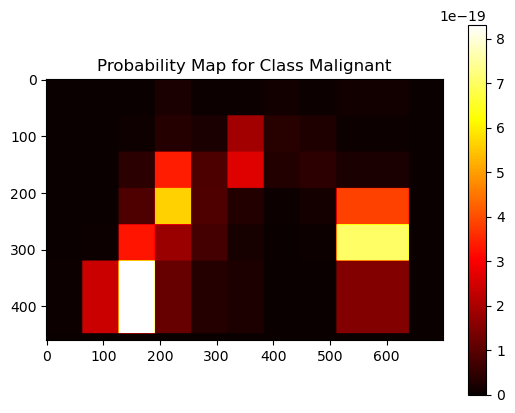

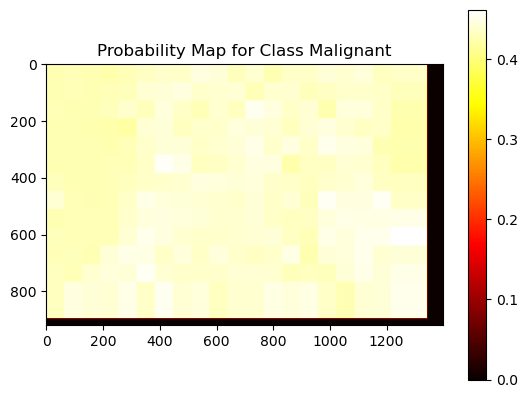

In [39]:
import numpy as np
import cv2

def get_probability_map(cnn_model, image, patch_size, stride, num_classes=2):
    """
    Generate a probability map for the entire image using a CNN model.

    Args:
        cnn_model: Trained CNN model.
        image: Input image (as a numpy array).
        patch_size: Size of the patches to extract from the image (tuple: (height, width)).
        stride: Stride to move the patch extraction window.
        num_classes: Number of classes (for classification).

    Returns:
        prob_map: A probability map (2D array) where each pixel contains the probability
                  of being in a certain class.
    """
    # Get the image dimensions
    height, width, _ = image.shape

    # Initialize a map to store probabilities for each pixel
    prob_map = np.zeros((height, width, num_classes))  # Probability map for each class

    # Loop through the image and extract patches
    for y in range(0, height - patch_size[0] + 1, stride):
        for x in range(0, width - patch_size[1] + 1, stride):
            # Extract the patch
            patch = image[y:y+patch_size[0], x:x+patch_size[1]]
            patch_resized = cv2.resize(patch, patch_size).astype('float32') / 255.0  # Normalize patch

            # Get model prediction (probabilities for each class)
            prob = cnn_model.predict(np.expand_dims(patch_resized, axis=0))[0]

            # Assign the predicted probabilities to the probability map
            prob_map[y:y+patch_size[0], x:x+patch_size[1], :] = prob

    return prob_map

# Example usage for the test image
image_100x = cv2.imread('dataset2/100x/malignant/SOB_M_PC-14-15704-100-007.png')  # Replace with your image path
image_200x = cv2.resize(image_100x, (image_100x.shape[1] * 2, image_100x.shape[0] * 2), interpolation=cv2.INTER_LANCZOS4)

patch_size = (128, 128)  # Example patch size (64x64 pixels)
stride = 64  # Example stride (32 pixels)
num_classes = 2  # Example for binary classification

# Assuming cnn_model is your trained CNN model
prob_map_100x = get_probability_map(cnn_100x, image_100x, patch_size, stride, num_classes)
# Assuming cnn_model is your trained CNN model
prob_map_200x = get_probability_map(cnn_200x, image_200x, patch_size, stride, num_classes)

# To visualize the probability map for class 1 (e.g., for binary classification)
import matplotlib.pyplot as plt
plt.imshow(prob_map_100x[:, :, 1], cmap='hot')  # Show the probability for class 1
plt.colorbar()
plt.title('Probability Map for Class Malignant')
plt.show()

plt.imshow(prob_map_200x[:, :, 1], cmap='hot')  # Show the probability for class 1
plt.colorbar()
plt.title('Probability Map for Class Malignant')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━

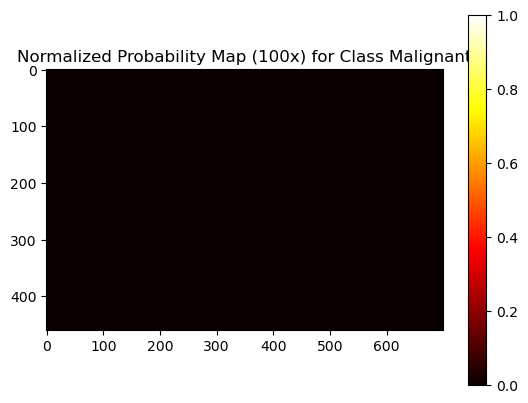

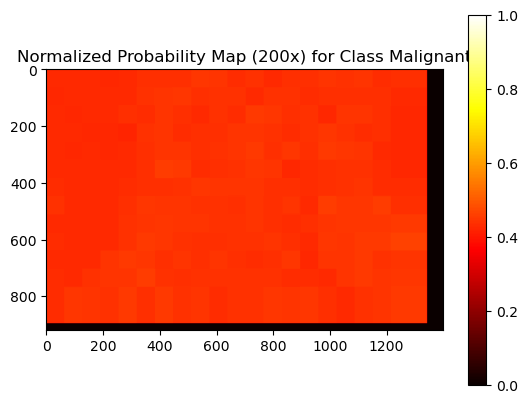

In [41]:
import numpy as np
import cv2

def get_probability_map(cnn_model, image, patch_size, stride, num_classes=2):
    """
    Generate a probability map for the entire image using a CNN model.

    Args:
        cnn_model: Trained CNN model.
        image: Input image (as a numpy array).
        patch_size: Size of the patches to extract from the image (tuple: (height, width)).
        stride: Stride to move the patch extraction window.
        num_classes: Number of classes (for classification).

    Returns:
        prob_map: A probability map (2D array) where each pixel contains the probability
                  of being in a certain class (values scaled between 0 and 1).
    """
    # Get the image dimensions
    height, width, _ = image.shape

    # Initialize a map to store probabilities for each pixel
    prob_map = np.zeros((height, width, num_classes))  # Probability map for each class

    # Loop through the image and extract patches
    for y in range(0, height - patch_size[0] + 1, stride):
        for x in range(0, width - patch_size[1] + 1, stride):
            # Extract the patch
            patch = image[y:y+patch_size[0], x:x+patch_size[1]]
            patch_resized = cv2.resize(patch, patch_size).astype('float32') / 255.0  # Normalize patch

            # Get model prediction (probabilities for each class)
            prob = cnn_model.predict(np.expand_dims(patch_resized, axis=0))[0]

            # Assign the predicted probabilities to the probability map
            prob_map[y:y+patch_size[0], x:x+patch_size[1], :] = prob

    # Scale the probability map to ensure values are between 0 and 1
    prob_map = np.clip(prob_map, 0, 1)

    return prob_map

# Example usage for the test image
image_100x = cv2.imread('dataset2/100x/malignant/SOB_M_PC-14-15704-100-007.png')  # Replace with your image path
image_200x = cv2.resize(image_100x, (image_100x.shape[1] * 2, image_100x.shape[0] * 2), interpolation=cv2.INTER_LANCZOS4)

patch_size = (128, 128)  # Example patch size
stride = 64  # Example stride
num_classes = 2  # Example for binary classification

# Assuming cnn_model is your trained CNN model
prob_map_100x = get_probability_map(cnn_100x, image_100x, patch_size, stride, num_classes)
prob_map_200x = get_probability_map(cnn_200x, image_200x, patch_size, stride, num_classes)

# Visualizing the normalized probability map for class 1
import matplotlib.pyplot as plt

plt.imshow(prob_map_100x[:, :, 1], cmap='hot', vmin=0, vmax=1)  # Show the probability for class 1
plt.colorbar()
plt.title('Normalized Probability Map (100x) for Class Malignant')
plt.show()

plt.imshow(prob_map_200x[:, :, 1], cmap='hot', vmin=0, vmax=1)  # Show the probability for class 1
plt.colorbar()
plt.title('Normalized Probability Map (200x) for Class Malignant')
plt.show()
